In [1]:
import pandas as pd

df = pd.read_csv("../DATA/user_problem_rating.csv", index_col=0)
df

,36,37,38,39,40,41,42,43,44,45,...,5218,5219,5220,5221,5222,5223,5224,5225,5226,5227
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71967,3,4,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71968,1,4,1,3,2,1,3,4,2,5,...,0,0,0,0,0,0,0,0,0,0
71969,4,0,0,4,0,0,0,0,5,5,...,0,0,0,0,0,0,0,0,0,0
71970,0,0,5,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df = df.sample(n=1000)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class NetflixPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, bin_edges = [1, 3, 6, 9, 12], max_rating = 5):
        self.max_rating = max_rating
        self.bin_edges = bin_edges

    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        bin_edges = [-float('inf')] + self.bin_edges + [float('inf')]
        bin_labels = [0] + [rating for rating in range(self.max_rating, 0)]

        for col in X.columns:
            X[col] = pd.cut(X[col], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)
        return X

In [4]:
from scipy import sparse

df_matrix = sparse.csr_matrix(df)
df_matrix

<1000x5192 sparse matrix of type '<class 'numpy.int64'>'
	with 44202 stored elements in Compressed Sparse Row format>

In [5]:
df_avg = dict()
# get the global average of ratings in our train set.
df_average = df_matrix.sum()/df_matrix.count_nonzero()
df_avg['global'] = df_average
df_avg

{'global': 4.420094113388535}

In [7]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [8]:
df_avg['user'] = get_average_ratings(df_matrix, of_users=True)
df_avg['movie'] =  get_average_ratings(df_matrix, of_users=False)

In [9]:
# get users, movies and ratings from our samples train sparse matrix
train_users, train_movies, train_ratings = sparse.find(df_matrix)

In [10]:
import datetime
from sklearn.metrics.pairwise import cosine_similarity

def make_rating_data(data_users, data_movies, data_ratings):
    final_data = pd.DataFrame(columns=["user", "movie", "global_avg", "user_s1", "user_s2", "user_s3", "user_s4", "movie_s5", "movie_s1", "movie_s2", "movie_s3", "movie_s4", "movie_s5", "avg_user_rating", "avg_movie_rating", "rating"])
    count = 0
    for (user, movie, rating) in zip(data_users, data_movies, data_ratings):
                #--------------------- Ratings of "movie" by similar users of "user" ---------------------
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(df_matrix[user], df_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = df_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([df_avg['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            #     print(top_sim_users_ratings, end=" ")    


                #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(df_matrix[:,movie].T, df_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = df_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([df_avg['user'][user]]*(5-len(top_sim_movies_ratings))) 
            #     print(top_sim_movies_ratings, end=" : -- ")

                #-----------------prepare the row to be stores in a file-----------------#
                row = list()
                row.append(user)
                row.append(movie)
                # Now add the other features to this data...
                row.append(df_avg['global']) # first feature
                # next 5 features are similar_users "movie" ratings
                row.extend(top_sim_users_ratings)
                # next 5 features are "user" ratings for similar_movies
                row.extend(top_sim_movies_ratings)
                # Avg_user rating
                row.append(df_avg['user'][user])
                # Avg_movie rating
                row.append(df_avg['movie'][movie])

                # finalley, The actual Rating of this user-movie pair...
                row.append(rating)
                count = count + 1
                final_data = pd.concat([final_data, pd.DataFrame([row])], ignore_index=True)
                print("Is in row:", count)
    return final_data

In [9]:
final_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,4.321047,3.0,5.0,1.0,2.0,5.0,3.0,4.0,3.0,3.0,3.0,3.000000,3.250518,2
1,1,0,4.321047,1.0,4.0,5.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.250518,4
2,5,0,4.321047,4.0,4.0,5.0,3.0,3.0,4.0,5.0,4.0,5.0,5.0,4.636364,3.250518,5
3,6,0,4.321047,5.0,2.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.894928,3.250518,5
4,7,0,4.321047,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.368421,3.250518,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39226,420,5060,4.321047,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.767591,5.000000,5
39227,420,5137,4.321047,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.767591,5.000000,5
39228,420,5144,4.321047,4.0,4.5,4.5,4.5,4.5,5.0,5.0,5.0,3.0,5.0,4.767591,4.500000,5
39229,650,5144,4.321047,5.0,4.5,4.5,4.5,4.5,3.0,5.0,5.0,4.0,5.0,4.636364,4.500000,4


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_validate

# prepare train data
X = final_data.drop([0, 1, 15], axis=1)
y = final_data[15]

rmse = make_scorer(mean_squared_error, squared=False)
mape = make_scorer(mean_absolute_percentage_error)

In [42]:
# List of models to compare
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(random_state=0)),
    ("SVM Regressor", SVR(kernel="linear")),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=0)),
    ("XGBoost", xgb.XGBRegressor(silent=False, random_state=0, n_estimators=100))
]

In [38]:
def get_scores(results):
    return (results["test_RMSE"], results["test_MAPE"])

results = {"xgb":get_scores(xgb_results), "linear":get_scores(l_results)}

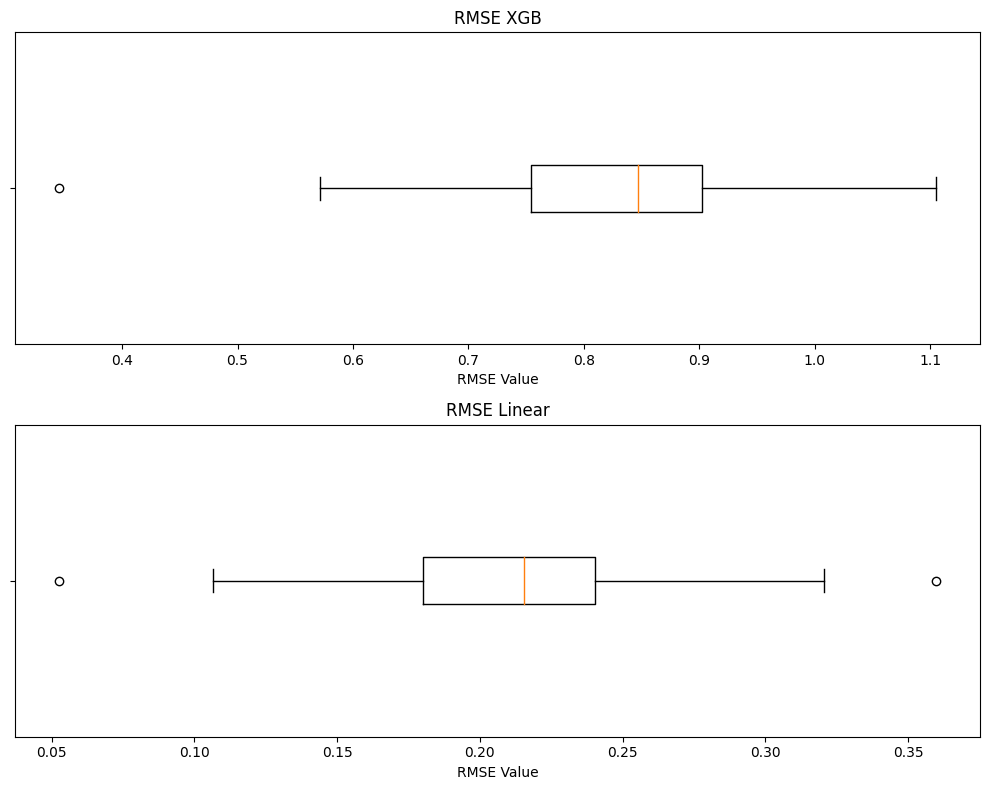

In [39]:
from matplotlib import pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Box plot for RMSE
axes[0].boxplot(results["xgb"][0], vert=False)
axes[0].set_title('RMSE XGB')
axes[0].set_xlabel('RMSE Value')
axes[0].set_yticklabels([])  # Hide y-axis labels

axes[1].boxplot(results["xgb"][1], vert=False)
axes[1].set_title('RMSE Linear')
axes[1].set_xlabel('RMSE Value')
axes[1].set_yticklabels([])  # Hide y-axis labels

plt.tight_layout()
plt.show()